In [8]:
import sys 
sys.path.append("./modules/")
from markov import *
from mva import *
from simulation import *
import platform

In [10]:
# variables

SystemParameters.alpha = 0.8
SystemParameters.beta = 0.2
SystemParameters.u1 = 15
SystemParameters.u2 = 75
SystemParameters.thinkTime = 5000
SystemParameters.timeSlice = 3
SystemParameters.numClients = 3
SystemParameters.Sio1 = 40
SystemParameters.Sio2 = 180
SystemParameters.qio1 = 0.65 #route to io1
SystemParameters.qio2 = 0.25 # route to io2
SystemParameters.qoutd = 0.1*0.4 #go to delay station
SystemParameters.qouts = 0.1*0.6 # renter the system

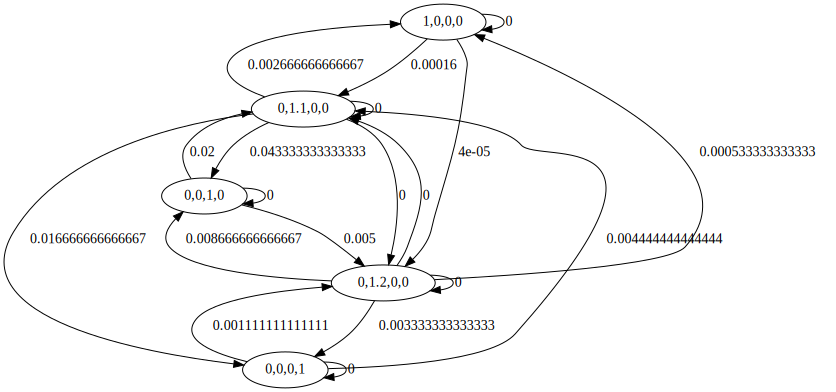

In [11]:
SystemParameters.numClients = 1
generator = ChainGenerator(node_enumerator())
generator(State(SystemParameters.numClients,0,0,0))
Printer.nx_to_graphviz(generator.chain())

In [24]:
matrix = np.array([
    [0,1,0,0,0],
    [0,0,1,0,0],
    [0.004,0.006,0.9,0.065,0.025],
    [0,0,1,0,0],
    [0,0,1,0,0]],np.dtype('d'))


mva = MVA(matrix,[5000,0,2.7,40,180],[StationType.Delay,StationType.LoadIndependent,StationType.LoadIndependent,StationType.LoadIndependent,StationType.LoadIndependent],30)


def produce_graph_and_save(dataframe: pd.DataFrame, name:str, yaxis:str, log:bool = False):
    fig = plt.line(dataframe,y=["CPU","SWAP_IN","IO1","IO2"], x="N",title=name,log_y=log)
    fig.update_yaxes(title_text=yaxis)
    data = fig.to_image("png")
    f = open("./Images/{}.png".format(name),"+wb")
    f.write(data)
    f.close()
    fig.show()
pass

mva()

utilization = mvaToDataframe(mva.utilizations)
throughputs = mvaToDataframe(mva.throughputs)
meanWaits = mvaToDataframe(mva.meanwaits)
meanClients = mvaToDataframe(mva.meanclients)


In [25]:
produce_graph_and_save(utilization,"Utilizations_markov","B/T")

In [26]:
produce_graph_and_save(meanWaits,"meanWaits_markov","ms",True)

In [27]:
produce_graph_and_save(meanClients,"meanClients_markov","n")

In [28]:
produce_graph_and_save(throughputs,"throughputs_markov","C/T")

legend (Delay_station,CPU.Stage,IO1,IO2)


In [29]:
commander = SimulatorCommander()
markov20 = commander.fetch_data(10,"Markov_20")
markov20_negexp = commander.fetch_data(10,"Markov_20_NegExp")

In [30]:
SystemParameters.numClients = 3
markov20["Expected"] = [execute_markov()[1]] * len(markov20)



5.626005999481229e-16
0.9999999999999994
Len  30
Ndelay 1.8451075757515112 Expected 1.857884604525876
Ncpu 0.31020059200934086 Expected 0.29853861389602415
Nio1 0.28790226992441775 Expected 0.28564336304184074
Nio2 0.5567895623147284 Expected 0.557933418536259
Mean execution time 27.0


In [31]:
SystemParameters.u1 = 27
SystemParameters.u2 = 27
SystemParameters.alpha = 0.5
SystemParameters.beta= 0.5 
markov20_negexp["Expected"]= [execute_markov()[1]]*len(markov20)

7.397983253350961e-16
1.0000000000000004
Len  30
Ndelay 1.857884606909605 Expected 1.857884604525876
Ncpu 0.2985386141856894 Expected 0.29853861389602415
Nio1 0.285643363143042 Expected 0.28564336304184074
Nio2 0.5579334157616656 Expected 0.557933418536259
Mean execution time 27.0


In [32]:
def print_cpu_measure(data: pd.DataFrame, scenario, measure):
    view = data[(data["Station"] == "CPU")& (data["Measure"] == measure)]
    fig = plt.line(view, x="Simulation" , y=["LB","HB","R","Expected"], title="{} CPU scenario {}".format(measure,scenario))
    return fig,view
    pass

fig,view = print_cpu_measure(markov20,"Markov","meanclients")
fig.show()

In [33]:

fig,view = print_cpu_measure(markov20,"Markov","meanwaits")
fig.show()

In [34]:
fig,view = print_cpu_measure(markov20_negexp,"Markov_negexp","meanclients")
fig.show()